In [ ]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import importlib
import gpudrive
importlib.reload(gpudrive)

import numpy as np
import os
import torch
from pathlib import Path

# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (5, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline

In [ ]:
FOLDER = "examples/eval/figures_data/wosac/storage_32R_full/"

FILES = [
    f"{FOLDER}score_dist_log_replay_density_0.001_2025-05-26-15.csv",
    f"{FOLDER}score_dist_log_replay_density_0.50_2025-05-26-18.csv",
    f"{FOLDER}score_dist_log_replay_density_1.00_2025-05-26-16.csv",
]
densities = [0.01, 0.5, 1.0]

# Load dataframes from files and merge into a single dataframe
dfs = []
for idx, file in enumerate(FILES):
    df = pd.read_csv(file)
    df["guidance_density"] = densities[idx]
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

ORDER = [1.0, 0.5, 0.01]

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
 # Create aggregated metrics
df["Kinematic metrics"] = (
    df["linear_speed_likelihood"] 
    + df["linear_acceleration_likelihood"]
    + df["angular_speed_likelihood"]
    + df["angular_acceleration_likelihood"]
) / 4

df["Interactive metrics"] = (
    df["collision_indication_likelihood"] 
    + df["time_to_collision_likelihood"]
    + df["distance_to_nearest_object_likelihood"]
) / 3

df["Map-based metrics"] = (
    df["distance_to_road_edge_likelihood"] 
    + df["offroad_indication_likelihood"]
) / 2


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

sns.barplot(
    data=df,
    x="guidance_density",
    y="metametric",
    order=ORDER,
    errorbar="sd",
)
axs.bar_label(axs.containers[0], fontsize=10)
axs.set_xlabel("Guidance density", fontsize=12)
axs.set_ylabel("WOSAC composite score", fontsize=12)

sns.despine()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

sns.lineplot(
    data=df,
    x="guidance_density",
    y="metametric",
    #order=ORDER,
    errorbar="se",
    markers=True,
    marker="o",
    label="Guided self-play"
)
#axs.bar_label(axs.containers[0], fontsize=10)
axs.set_xlabel("Guidance density", fontsize=14)
axs.set_ylabel("WOSAC realism meta-metric", fontsize=14)
axs.set_xticks(ORDER)
axs.set_xticklabels(ORDER)
axs.invert_xaxis()
axs.grid(True, alpha=0.2, axis="y")
axs.set_ylim(0.75, 0.79)

# Add horizontal line at y=0.75
#axs.axhline(y=0.777, color="darkgrey", linestyle="--", label="SMART")
#axs.axhline(y=0.8137, color="darkgreen", linestyle="-", label="Logged oracle")

plt.legend()
sns.despine()

# Save the figure
fig.savefig(
    f"{FOLDER}score_dist_log_replay_density_v0.pdf",
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))

sns.lineplot(
    data=df,
    x="guidance_density",
    y="Kinematic metrics",
    errorbar="se",
    markers=True,
    marker="o",
    ax=axs[0],    
    color='r',
)


axs[0].set_xlabel("Guidance density", fontsize=14)
axs[0].set_ylabel("Kinematic metrics", fontsize=14)
axs[0].set_xticks(ORDER)
axs[0].set_xticklabels(ORDER)
axs[0].invert_xaxis()
axs[0].grid(True, alpha=0.2, axis="y")

sns.lineplot(
    data=df,
    x="guidance_density",
    y="Interactive metrics",
    errorbar="se",
    markers=True,
    marker="o",
    ax=axs[1],    
    color='purple',
)


axs[1].set_xlabel("Guidance density", fontsize=14)
axs[1].set_ylabel("Interactive metrics", fontsize=14)
axs[1].set_xticks(ORDER)
axs[1].set_xticklabels(ORDER)
axs[1].invert_xaxis()
axs[1].grid(True, alpha=0.2, axis="y")

sns.lineplot(
    data=df,
    x="guidance_density",
    y="Map-based metrics",
    errorbar="se",
    markers=True,
    marker="o",
    ax=axs[2],    
    color='g',
)


axs[2].set_xlabel("Guidance density", fontsize=14)
axs[2].set_ylabel("Map-based metrics", fontsize=14)
axs[2].set_xticks(ORDER)
axs[2].set_xticklabels(ORDER)
axs[2].invert_xaxis()
axs[2].grid(True, alpha=0.2, axis="y")

sns.lineplot(
    data=df,
    x="guidance_density",
    y="min_average_displacement_error",
    errorbar="se",
    markers=True,
    marker="o",
    ax=axs[3],    
    color='g',
)


axs[3].set_xlabel("Guidance density", fontsize=14)
axs[3].set_ylabel("MinADE", fontsize=14)
axs[3].set_xticks(ORDER)
axs[3].set_xticklabels(ORDER)
axs[3].invert_xaxis()
axs[3].grid(True, alpha=0.2, axis="y")

plt.tight_layout()

# Save the figure
fig.savefig(
    f"{FOLDER}score_categories_density_v1.pdf",
    dpi=300,
    bbox_inches="tight",
)

sns.despine()

## Error distributions

In [ ]:
#df = df[df["guidance_density"] == 0.01]

In [ ]:
# Load df
df = pd.read_csv("/home/emerge/gpudrive/examples/eval/figures_data/wosac/score_dist_log_replay_density_0.05_2025-05-31-15.csv")

In [ ]:
df.sort_values(by="metametric", ascending=True, inplace=True)

df

In [ ]:
sns.histplot(
    data=df,
    x="metametric",
);

In [ ]:
sns.histplot(
    data=df_ep,
    x="metametric",
    kde=False,
    stat="density",
    bins=30,
    color="b",
    alpha=0.5,
);

In [ ]:
sns.histplot(
    data=df_ep,
    x="Map-based metrics",
    kde=False,
    stat="density",
    bins=30,
    color="b",
    alpha=0.5,
);

## Benchmark to other approaches


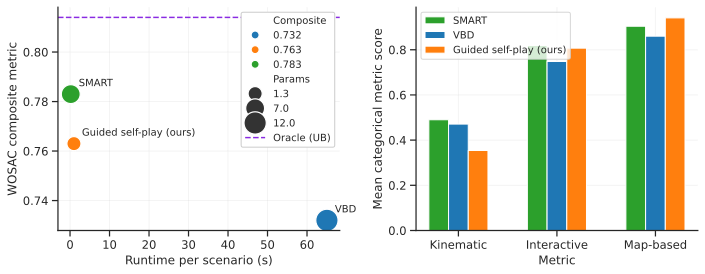

In [25]:
data = {
    'Method': ['SMART', 'VBD', 'Guided self-play (ours)'],
    'Model_Size': ['7 M', '12 M', '1.3 M'],
    'Composite': [0.783, 0.732, 0.763],
    'Kinematic': [0.490, 0.471, 0.354],
    'Interactive': [0.819, 0.748, 0.807],
    'Map-based': [0.904, 0.860, 0.941],
    'minADE_m': [1.17, 1.734, 2.708],
    'Collision_Rate': [0.008, 0.107, 0.000],
    'Offroad_Rate': [0.027, 0.108, 0.05]
}

df = pd.DataFrame(data)

# Add runtime information
runtime_data = {
    'SMART': 0.1859,
    'VBD': 65.04,
    'Guided self-play (ours)': 0.9889
}

runtime_std = {
    'SMART': 0.0211,
    'VBD': 1.42,
    'Guided self-play (ours)': 0.4612
}

df['Mean_Runtime_s'] = df['Method'].map(runtime_data)
df['Std_Runtime_s'] = df['Method'].map(runtime_std)
df['Params'] = df['Model_Size'].str.replace(' M', '').astype(float)
plot_df = df


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(
    data=plot_df,
    x="Mean_Runtime_s",
    y="Composite",
    hue="Composite", 
    size="Params",
    sizes=(200, 500),
    ax=ax1,
    palette='tab10',
)

for _, row in plot_df.iterrows():
    ax1.annotate(row['Method'], 
                 (row['Mean_Runtime_s'], row['Composite']),
                 xytext=(8, 8), textcoords='offset points',
                 fontsize=10, alpha=1.0)
# horizontal line for SMART
ax1.axhline(y=0.814, color='blueviolet', linestyle='--', label='Oracle (UB)')
ax1.set_xlabel('Runtime per scenario (s)', fontsize=12)
ax1.set_ylabel('WOSAC composite metric', fontsize=12)
ax1.legend(loc='upper right', fontsize=10, title_fontsize='13', framealpha=1.0, facecolor='white')
ax1.grid(True, alpha=0.2)

# Second subplot: Bar plot - ONLY THIS SECTION CHANGED
metrics = ['Kinematic', 'Interactive', 'Map-based']
methods = df['Method']
x = np.arange(len(metrics))
width = 0.2

method_colors = ["tab:green", "tab:blue", "tab:orange"]  
for i, method in enumerate(methods):
    values = [df.loc[df['Method'] == method, metric].iloc[0] for metric in metrics]
    ax2.bar(x + i*width, values, width, label=method, 
            alpha=1.0, color=method_colors[i])

ax2.set_xlabel('Metric', fontsize=12)
ax2.set_ylabel('Mean categorical metric score', fontsize=12)
#ax2.set_title('Performance Metrics by Method', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width)
ax2.set_xticklabels(metrics)
ax2.legend(fontsize=10, title_fontsize='13', loc='upper left', facecolor='white')
ax2.grid(True, alpha=0.2)
sns.despine()

plt.tight_layout()
# plt.show()

# save the figure as pdf
fig.savefig(
    f"wosac_benchmarking.pdf",
    dpi=300,
    bbox_inches="tight",
)